In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *
from ReadData import *
from GetJSON import get

In [3]:
totalDataDF = pd.read_csv('../data/totalDataDF.csv', header=0, index_col=0)

In [4]:
g, n = totalDataDF.shape
k = 325

In [5]:
binaryPathwayDF = pd.read_csv('../data/pathways.tsv', sep='\t', header=0)

In [17]:
totalDataDF = totalDataDF.loc[binaryPathwayDF['Genes']]

/homes/gws/psturm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [19]:
totalDataDF.head()

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,1021204186,3451205016,4971205156,5371205166,1731204246,1321204196,4291205076,1081204186,651204176,2581204266
PCG,,,,,,,,,,,,,,,,,,,,,
A1BG,0.713793,0.802296,0.892630,0.735225,0.747652,0.743722,0.777267,0.667098,0.696835,0.746391,...,0.486455,0.383081,0.337306,0.403970,0.476717,0.624009,0.496616,0.362725,0.472031,0.273828
A1CF,0.419965,0.426178,0.315480,0.686560,0.631619,0.620870,0.648269,0.688486,0.603277,0.683848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.367383,0.613653,0.638912,0.498370,0.690675,0.477446,0.553477,0.478333,0.451581,0.663223,...,0.566776,0.491193,0.361478,0.654809,0.659928,0.368710,0.340877,0.539402,0.341240,0.251596
A2ML1,0.369900,0.694698,0.549104,0.409760,0.680194,0.513498,0.567791,0.584054,0.532588,0.617017,...,0.183321,0.626303,0.668257,0.810873,0.726700,0.280490,0.412534,0.557669,0.414878,0.544581


In [30]:
binaryPathwayDF.set_index('Genes', inplace=True)
binaryPathwayDF.head()

,REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS,REACTOME_TRANSLATION,REACTOME_PYRIMIDINE_CATABOLISM,REACTOME_RNA_POL_III_TRANSCRIPTION_INITIATION_FROM_TYPE_2_PROMOTER,REACTOME_INHIBITION_OF_THE_PROTEOLYTIC_ACTIVITY_OF_APC_C_REQUIRED_FOR_THE_ONSET_OF_ANAPHASE_BY_MITOTIC_SPINDLE_CHECKPOINT_COMPONENTS,REACTOME_PYRUVATE_METABOLISM_AND_CITRIC_ACID_TCA_CYCLE,REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PTM_GAMMA_CARBOXYLATION_HYPUSINE_FORMATION_AND_ARYLSULFATASE_ACTIVATION,REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS,REACTOME_RNA_POL_I_TRANSCRIPTION_TERMINATION,...,REACTOME_DIGESTION_OF_DIETARY_CARBOHYDRATE,REACTOME_FGFR1_LIGAND_BINDING_AND_ACTIVATION,REACTOME_GAP_JUNCTION_ASSEMBLY,REACTOME_SYNTHESIS_OF_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI,REACTOME_RNA_POL_I_TRANSCRIPTION_INITIATION,REACTOME_PYRIMIDINE_METABOLISM,REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PI3K_CASCADE,REACTOME_APOPTOTIC_EXECUTION_PHASE,REACTOME_SHC_RELATED_EVENTS
Genes,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2LD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X = totalDataDF.values.T
binaryPathwayMat = binaryPathwayDF.values

In [34]:
neighbors = GetNeighborDictionary(binaryPathwayMat)

In [ ]:
import time
start = time.time()
U, V = CreateLatentVariables(n, g, k)
U, V, trainError, testError = FactorizeMatrix(X, U, V, neighbors=None, eta=0.005, lamb1=0.02, lamb2=0.001, 
                    num_epochs=1, trainIndices=None, testIndices=None, returnErrorVectors=True)
end =  time.time()
print('Time taken to train a single epoch: {}'.format(end - start))

In [ ]:
num_folds=5
hyper_params = RandomParams(eta_low=0.001, eta_high=0.01, lamb1_low=0.01, lamb1_high=0.04, lamb2_low=0.001, lamb2_high=0.02, num_reps=50)
errorsDF, trainErrorDF, testErrorDF = CrossValidation(X, k, hyper_params, neighbors=neighbors, foldcount=num_folds, returnVectorDF=True)

In [ ]:
def GetMeanErrorDF(errorsDF, num_folds=5):
    meanErrorsDF = pd.concat([errorsDF[errorsDF['fold'] == i].drop('fold', axis=1).reset_index(drop=True) for i in range(num_folds)], axis=0)
    meanErrorsDF = meanErrorsDF.groupby(meanErrorsDF.index).mean()
    return meanErrorsDF

In [52]:
meanErrorsDf = GetMeanErrorDF(errorsDF, num_folds)
bestParamsIndex = meanErrorsDf['error'].idxmin(axis=1)
print(meanErrorsDf.iloc[bestParamsIndex])

eta      0.005026
lamb1    0.010103
lamb2    0.009838
error    0.016202
Name: 4, dtype: float64


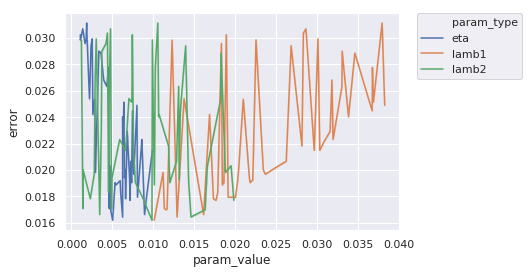

In [56]:
PlotParamDF(errorsDF)

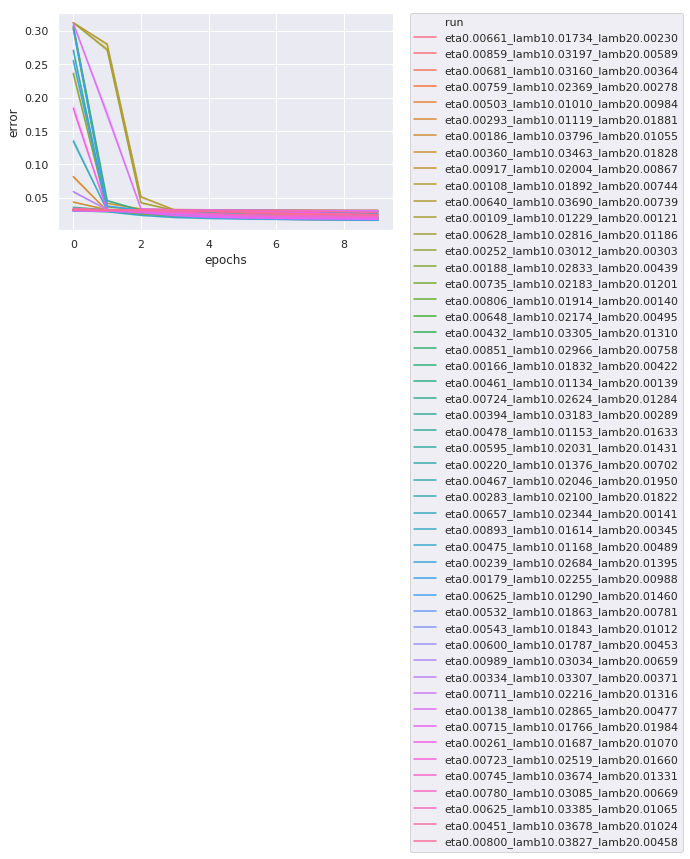

In [53]:
PlotErrorDF(testErrorDF)

In [ ]:
hyper_params_nn = RandomParams(eta_low=0.001, eta_high=0.02, lamb1_low=0.001, lamb1_high=0.04, lamb2_low=0.001, lamb2_high=0.02, num_reps=50)
errorsDF_nn, trainErrorDF_nn, testErrorDF_nn = CrossValidation(X, k, hyper_params_nn, neighbors={}, foldcount=5, returnVectorDF=True)

In [54]:
meanErrorsDf_nn = GetMeanErrorDF(errorsDF_nn, num_folds)
bestParamsIndex_nn = meanErrorsDf_nn['error'].idxmin(axis=1)
print(meanErrorsDf_nn.iloc[bestParamsIndex_nn])

eta      0.017397
lamb1    0.001877
lamb2    0.001442
error    0.009300
Name: 37, dtype: float64


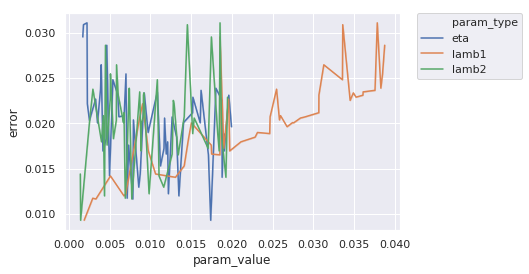

In [61]:
PlotParamDF(errorsDF_nn)

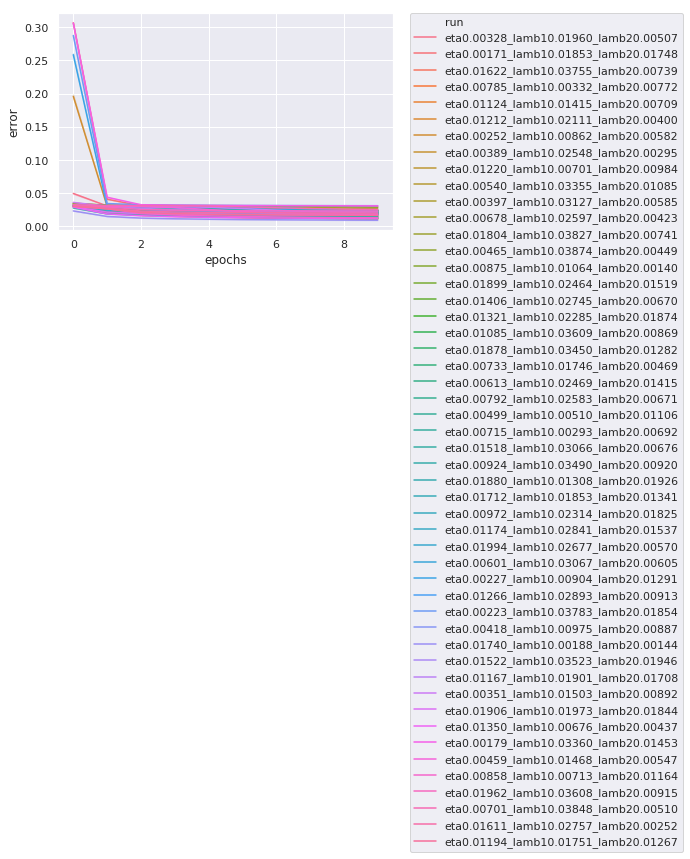

In [55]:
PlotErrorDF(testErrorDF_nn)

In [62]:
eta, lamb1, lamb2, _ = meanErrorsDf.iloc[bestParamsIndex].values
eta_nn, lamb1_nn, lamb2_nn, _ = meanErrorsDf_nn.iloc[bestParamsIndex_nn].values

In [57]:
errorsDF.to_csv('DataFrames/errorsDF.csv', index=False)

In [58]:
trainErrorDF.to_csv('DataFrames/trainErrorDF.csv', index=False)

In [59]:
testErrorDF.to_csv('DataFrames/testErrorDF.csv', index=False)

In [60]:
errorsDF_nn.to_csv('DataFrames/errorsDF_nn.csv', index=False)
trainErrorDF_nn.to_csv('DataFrames/trainErrorDF_nn.csv', index=False)
testErrorDF_nn.to_csv('DataFrames/testErrorDF_nn.csv', index=False)